In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Creating inspector object
inspector = inspect(engine)

In [11]:
# Inspecting measurement table using inspector
measurement_cols = inspector.get_columns('measurement')
for col in measurement_cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Inspecting station table using inspector
station_cols = inspector.get_columns('station')
for col in station_cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
stations= session.query(Station.station).all()
stations_list = list(np.ravel(stations))
stations_list

['USC00519397',
 'USC00513117',
 'USC00514830',
 'USC00517948',
 'USC00518838',
 'USC00519523',
 'USC00519281',
 'USC00511918',
 'USC00516128']

In [33]:
start_date = dt.datetime.strptime(start,'%Y-%m-%d')
temperatures = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date>=start_date).all()
# temperatures = list(np.ravel(temperatures))
temp_dict = temperatures.__dict__


AttributeError: 'list' object has no attribute '__dict__'

# Exploratory Climate Analysis

## Precipitation Analysis

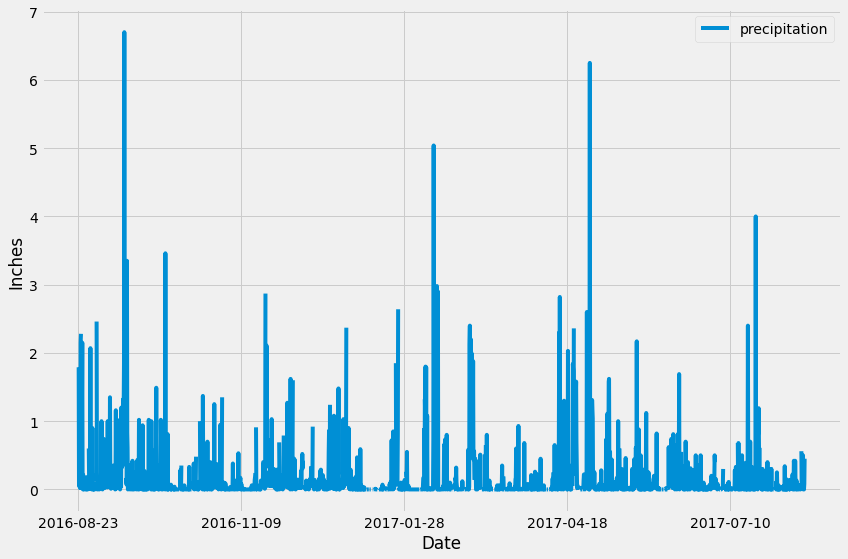

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Query the date of the last data point
last_point_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Convert last_point_date into a datetime object
lp_date_obj = dt.datetime.strptime(last_point_date[0],'%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = lp_date_obj - dt.timedelta(days=366)
one_year_ago

# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurements_df = pd.DataFrame(last_year_data, columns = ('date', 'precipitation'))

measurements_df.set_index('date',inplace=True)
measurements_df

# Sort the dataframe by date
measurements_df = measurements_df.sort_values(by='date', ascending=True)
measurements_df
# Use Pandas Plotting with Matplotlib to plot the data
ax = measurements_df.plot(figsize=(12,8))
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurements_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
most_active_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()[0]
most_active_station

'USC00519281'

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station==most_active_station).first()[0]
print(f'The lowest temp of the most active station is lowest_temp = {lowest_temp}')

highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station==most_active_station).first()[0]
print(f'The highest temp of the most active station is lowest_temp = {highest_temp}')

average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==most_active_station).first()[0]
print(f'The average temp of the most active station is lowest_temp = {round(average_temp,1)}')


The lowest temp of the most active station is lowest_temp = 54.0
The highest temp of the most active station is lowest_temp = 85.0
The average temp of the most active station is lowest_temp = 71.7


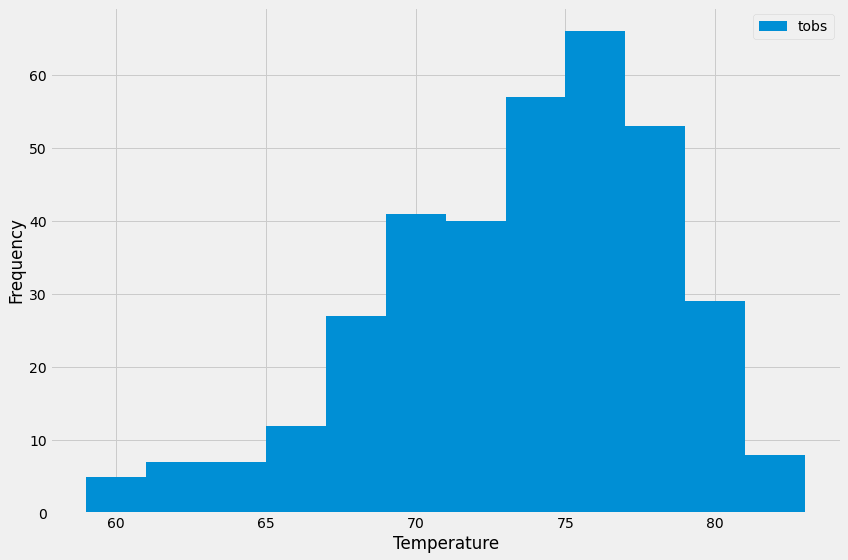

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
most_active_lastyear_temp = session.query(Measurement.tobs).filter((Measurement.station==most_active_station),\
                                                                   (Measurement.date>=one_year_ago)).all()
temp_list = [temp[0] for temp in most_active_lastyear_temp]
temp_list
#plot the results as a histogram
plt.figure(figsize=(12,8))
plt.hist(temp_list, bins=12)
plt.legend(('tobs',),loc='best')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
